In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Online Shoppers Intention Dataset

- Target Variable: Revenue.
This indicated whether a session resulted in a purchase (True or False)
- Categorical Variables: Month, VisitorType, Weekend
- Quantitative Variables: Administrative, Administrative_Duration, Informational, ProductRelated, BounceRates, ExitRates, PageValues

### Answering Questions in Project Description:

- Which variables are predictive of the target variable?
    -  Month, VisitorType, Weekend, Administrative, Administrative_Duration, Informational, ProductRelated, BounceRates, ExitRates, PageValues are predictive of the target variable Revenue

- Can logistic regression or a linear SVM predict well?
    - Both models can perform well on binary classification tasks. Logistic regression is straightforward and interpretable, while SVMs can handle non-linear boundaries if the data is transformed appropriately. 

- Is there a difference between the polynomial and RBF SVMs?
    - RBF appears to perform slightly better for this dataset

- What effect does changing the class_weight in an SVM have on your data? How might this be important for this data?
    - After adding class_weight of class_weight={0:0.25, 1:0.75}, the F-Scores for Linear SVMs went up from [0.53, 0.94] / [0.53, 0.94] for PageValues vs. ExitRates and PageValues vs. BounceRates to [0.63 0.94] and [0.62 0.94].

- Is there a difference in runtime performance?
    - SVM RBF took about .7 seconds while SVM Polynomial took double the time with 1.4 seconds

- Logistic regression and LinearSVC use one-vs-rest (OVR) for multi-class classification. SVC uses one-vs-one (OVO). Where n is the number of classes, OVR learns n models, whereas OVO learns n(n-1)/2 (n choose 2) models. What effect does this have on performance?
    - This drastically improves the performance of the OVO models, though might slow them down. Since they are looking at more models, it is able to better determine the decision boundery.

In [62]:
# load the dataset
df = pd.read_csv('online_shoppers_intention.csv')
df['Revenue'] = df['Revenue'].astype(int)
y = df['Revenue']

# select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# display the correlation of all features with 'Revenue'
revenue_correlation = correlation_matrix['Revenue'].sort_values(ascending=False)
print(revenue_correlation)

Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64


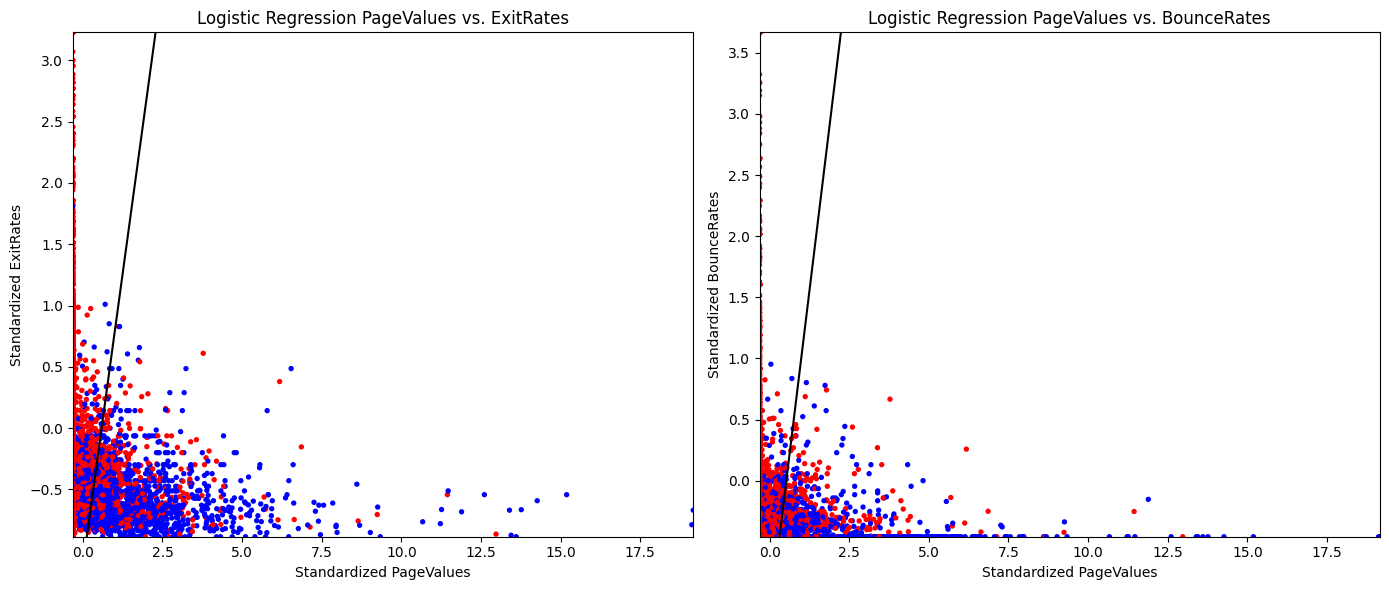

In [72]:
# select features with significant correlation & standardize it
selected_features = ['PageValues', 'ExitRates', 'BounceRates']
X_selected = df[selected_features]
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# train logistic regression models for the two sets of features
model_exit_rates = LogisticRegression(class_weight={0:0.25, 1:0.75})
model_exit_rates.fit(X_selected_scaled[:, [0, 1]], y)

model_bounce_rates = LogisticRegression(class_weight={0:0.25, 1:0.75})
model_bounce_rates.fit(X_selected_scaled[:, [0, 2]], y)

# define the range for x values based on the standardized features
plt.figure(figsize=(14, 6))
x_range = np.linspace(X_selected_scaled[:, 0].min(), X_selected_scaled[:, 0].max(), 200)

# calculate the decision boundary for 'ExitRates'
b0_exit_rates = model_exit_rates.intercept_[0]
b_exit_rates = model_exit_rates.coef_[0]
y_exit_rates = -(b0_exit_rates + b_exit_rates[0] * x_range) / b_exit_rates[1]

# calculate the decision boundary for 'BounceRates'
b0_bounce_rates = model_bounce_rates.intercept_[0]
b_bounce_rates = model_bounce_rates.coef_[0]
y_bounce_rates = -(b0_bounce_rates + b_bounce_rates[0] * x_range) / b_bounce_rates[1]

# define the color for the scatter plot
color = ['red' if y_ == 0 else 'blue' for y_ in y]

# plot for 'PageValues' and 'ExitRates'
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(X_selected_scaled[:, 0], X_selected_scaled[:, 1], c=color, s=8)
ax1.plot(x_range, y_exit_rates, color='black')
ax1.set_xlim(X_selected_scaled[:, 0].min(), X_selected_scaled[:, 0].max())
ax1.set_ylim(X_selected_scaled[:, 1].min(), X_selected_scaled[:, 1].max())
ax1.set_xlabel('Standardized PageValues')
ax1.set_ylabel('Standardized ExitRates')
ax1.set_title('Logistic Regression PageValues vs. ExitRates')

# plot for 'PageValues' and 'BounceRates'
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(X_selected_scaled[:, 0], X_selected_scaled[:, 2], c=color, s=8)
ax2.plot(x_range, y_bounce_rates, color='black')
ax2.set_xlim(X_selected_scaled[:, 0].min(), X_selected_scaled[:, 0].max())
ax2.set_ylim(X_selected_scaled[:, 2].min(), X_selected_scaled[:, 2].max())
ax2.set_xlabel('Standardized PageValues')
ax2.set_ylabel('Standardized BounceRates')
ax2.set_title('Logistic Regression PageValues vs. BounceRates')

plt.tight_layout()
plt.show()

In [73]:
# make predictions and calculate performance metrics for 'ExitRates'
y_pred_exit_rates = model_exit_rates.predict(X_selected_scaled[:, [0, 1]])
p_exit_rates, r_exit_rates, f_exit_rates, _ = precision_recall_fscore_support(y, y_pred_exit_rates, labels=[1, 0])

# make predictions and calculate performance metrics for 'BounceRates'
y_pred_bounce_rates = model_bounce_rates.predict(X_selected_scaled[:, [0, 2]])
p_bounce_rates, r_bounce_rates, f_bounce_rates, _ = precision_recall_fscore_support(y, y_pred_bounce_rates, labels=[1, 0])

print('Metrics for PageValues vs. ExitRates:')
print('Predicted range: [{:.2f},{:.2f}]'.format(min(y_pred_exit_rates), max(y_pred_exit_rates)))
print('Precision:', p_exit_rates)
print('Recall:', r_exit_rates)
print('F-score:', f_exit_rates)

print('\nMetrics for PageValues vs. BounceRates:')
print('Predicted range: [{:.2f},{:.2f}]'.format(min(y_pred_bounce_rates), max(y_pred_bounce_rates)))
print('Precision:', p_bounce_rates)
print('Recall:', r_bounce_rates)
print('F-score:', f_bounce_rates)

Metrics for PageValues vs. ExitRates:
Predicted range: [0.00,1.00]
Precision: [0.6809553  0.92558661]
Recall: [0.58280922 0.9500096 ]
F-score: [0.62807117 0.93763909]

Metrics for PageValues vs. BounceRates:
Predicted range: [0.00,1.00]
Precision: [0.67625    0.92301957]
Recall: [0.56708595 0.95029745]
F-score: [0.61687571 0.93645991]


In [78]:
df['Revenue'] = df['Revenue'].astype(int)
y = df['Revenue']

# train SVM models for the two sets of features with a linear kernel
svm_exit_rates = SVC(kernel='linear', class_weight={0:0.25, 1:0.75})
svm_exit_rates.fit(X_selected_scaled[:, [0, 1]], y)

svm_bounce_rates = SVC(kernel='linear', class_weight={0:0.25, 1:0.75})
svm_bounce_rates.fit(X_selected_scaled[:, [0, 2]], y)

# make predictions and calculate performance metrics for 'ExitRates' with a linear kernel
y_pred_exit_rates_svm = svm_exit_rates.predict(X_selected_scaled[:, [0, 1]])
p_exit_rates_svm, r_exit_rates_svm, f_exit_rates_svm, _ = precision_recall_fscore_support(y, y_pred_exit_rates_svm, labels=[1, 0])

# make predictions and calculate performance metrics for 'BounceRates' with a linear kernel
y_pred_bounce_rates_svm = svm_bounce_rates.predict(X_selected_scaled[:, [0, 2]])
p_bounce_rates_svm, r_bounce_rates_svm, f_bounce_rates_svm, _ = precision_recall_fscore_support(y, y_pred_bounce_rates_svm, labels=[1, 0])

# display evaluation metrics for SVM with a linear kernel
print('SVM Metrics with for PageValues vs. ExitRates:')
print('Predicted range: [{:.2f},{:.2f}]'.format(min(y_pred_exit_rates_svm), max(y_pred_exit_rates_svm)))
print('Precision:', p_exit_rates_svm)
print('Recall:', r_exit_rates_svm)
print('F-score:', f_exit_rates_svm)

print('\nSVM Metrics for PageValues vs. BounceRates:')
print('Predicted range: [{:.2f},{:.2f}]'.format(min(y_pred_bounce_rates_svm), max(y_pred_bounce_rates_svm)))
print('Precision:', p_bounce_rates_svm)
print('Recall:', r_bounce_rates_svm)
print('F-score:', f_bounce_rates_svm)


SVM Metrics with for PageValues vs. ExitRates:
Predicted range: [0.00,1.00]
Precision: [0.65611111 0.93095916]
Recall: [0.61897275 0.94060641]
F-score: [0.63700108 0.93575792]

SVM Metrics for PageValues vs. BounceRates:
Predicted range: [0.00,1.00]
Precision: [0.65611111 0.93095916]
Recall: [0.61897275 0.94060641]
F-score: [0.63700108 0.93575792]


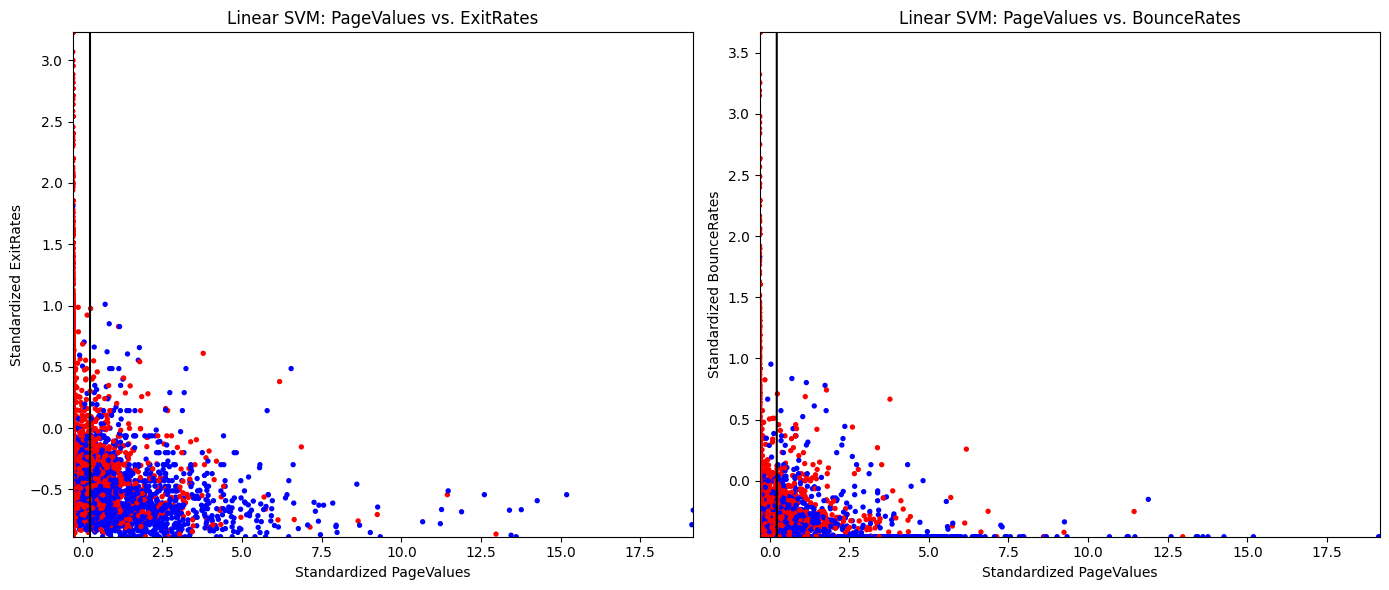

In [79]:
# Calculate the decision boundary for 'ExitRates' with the linear SVM model
coef_exit_rates_svm = svm_exit_rates.coef_[0]
intercept_exit_rates_svm = svm_exit_rates.intercept_[0]
y_exit_rates_svm = -(intercept_exit_rates_svm + coef_exit_rates_svm[0] * x_range) / coef_exit_rates_svm[1]

# Calculate the decision boundary for 'BounceRates' with the linear SVM model
coef_bounce_rates_svm = svm_bounce_rates.coef_[0]
intercept_bounce_rates_svm = svm_bounce_rates.intercept_[0]
y_bounce_rates_svm = -(intercept_bounce_rates_svm + coef_bounce_rates_svm[0] * x_range) / coef_bounce_rates_svm[1]

# Plotting the decision boundaries for SVM models
plt.figure(figsize=(14, 6))

# Plot for 'PageValues' and 'ExitRates' with SVM model
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(X_selected_scaled[:, 0], X_selected_scaled[:, 1], c=color, s=8)
ax1.plot(x_range, y_exit_rates_svm, color='black')
ax1.set_xlim(X_selected_scaled[:, 0].min(), X_selected_scaled[:, 0].max())
ax1.set_ylim(X_selected_scaled[:, 1].min(), X_selected_scaled[:, 1].max())
ax1.set_xlabel('Standardized PageValues')
ax1.set_ylabel('Standardized ExitRates')
ax1.set_title('Linear SVM: PageValues vs. ExitRates')

# Plot for 'PageValues' and 'BounceRates' with SVM model
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(X_selected_scaled[:, 0], X_selected_scaled[:, 2], c=color, s=8)
ax2.plot(x_range, y_bounce_rates_svm, color='black')
ax2.set_xlim(X_selected_scaled[:, 0].min(), X_selected_scaled[:, 0].max())
ax2.set_ylim(X_selected_scaled[:, 2].min(), X_selected_scaled[:, 2].max())
ax2.set_xlabel('Standardized PageValues')
ax2.set_ylabel('Standardized BounceRates')
ax2.set_title('Linear SVM: PageValues vs. BounceRates')

plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42)


In [80]:
# Train SVM with an RBF kernel
svm_rbf = SVC(kernel='rbf', class_weight={0:0.25, 1:0.75}) 
svm_rbf.fit(X_train, y_train)

# Evaluate the models on the testing set
print('Testing set evaluation:')
print('Polynomial SVM:')
print(classification_report(y_test, svm_poly.predict(X_test)))
print('RBF SVM:')
print(classification_report(y_test, svm_rbf.predict(X_test)))

Testing set evaluation:
Polynomial SVM:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3124
           1       0.75      0.43      0.55       575

    accuracy                           0.89      3699
   macro avg       0.83      0.70      0.74      3699
weighted avg       0.88      0.89      0.88      3699

RBF SVM:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3124
           1       0.60      0.72      0.65       575

    accuracy                           0.88      3699
   macro avg       0.77      0.82      0.79      3699
weighted avg       0.89      0.88      0.89      3699



In [81]:
# train SVM with a polynomial kernel
svm_poly = SVC(kernel='poly', degree=3, class_weight={0:0.25, 1:0.75})
svm_poly.fit(X_train, y_train)

# Evaluate the models on the training set
print('Training set evaluation:')
print('Polynomial SVM:')
print(classification_report(y_train, svm_poly.predict(X_train)))
print('RBF SVM:')
print(classification_report(y_train, svm_rbf.predict(X_train)))

Training set evaluation:
Polynomial SVM:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7298
           1       0.74      0.45      0.56      1333

    accuracy                           0.89      8631
   macro avg       0.82      0.71      0.75      8631
weighted avg       0.88      0.89      0.88      8631

RBF SVM:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7298
           1       0.61      0.73      0.66      1333

    accuracy                           0.88      8631
   macro avg       0.78      0.82      0.80      8631
weighted avg       0.90      0.88      0.89      8631

